# make heatmap of AA changes

probably going to use nb #1 missense_table, but need to make a longer table
- each codon has a single doped NT
- list all the AAs encoded by that new doped codon

In [13]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pickle


In [2]:
# next is to go from a sequence to a heatmap
# requires sequence and position filter

# input
protein = 'K3L'
seq = 'atgCTTgcattttgttattcgttgcccaatgcgggtgatgtaataaagggcagagtatacgagaaggattatgctctatatatttatctttttgactatcctcactttgaagctatcttggcagagagtgttaagatgcatatggatagatatgttgaatatagggataaactggtagggaaaactgtaaaagttaaagtgattagagttgattatacaaaaggatatatagatgtcaattacaaaaggatgtgtagacatcaatag'
mut_pos = [(2,88)]

# get list of codons
seq = seq.upper()
codons = [seq[i:i+3] for i in range(0, len(seq), 3)]

# make df of wt and iupac
mis_df = pd.read_csv('../data/dms_variants_210303/missense_table.csv')

data = {'codon':codons}
df = pd.DataFrame(data)
# merge the two
df = pd.merge(df, mis_df[['codon','aa','mis_var']], how='left', on='codon')

# convert string into list of characters
df.mis_var = df.mis_var.apply(lambda x:list(x))

# create a T/F df based on AA abbreviations
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
df2 = boolean_df(df.mis_var, aa_list)
df2 = df2.astype(int)

# replace all "0" with "na"
df2.replace(0,np.nan, inplace=True)

# change all 
mut_pos_list = []
for win in mut_pos:
        mut_pos_list.append(list(range(win[0]-1,win[1])))
mut_pos_list = list(itertools.chain.from_iterable(mut_pos_list))

# change all values not in filter to "na"
df2.loc[~df.index.isin(mut_pos_list)] = np.nan

# add in the wt aa with a value of "2"
df3 = df.join(df2)
for index,row in df3.iterrows():
    wt_aa = row['aa']
    df3.loc[index, wt_aa] = 2

# increase index by 1 for residue position
df3.index = df3.index + 1

# add count of missense variants
df3['variant_sum'] = df3[aa_list].sum(axis=1) - 2 #-2 is b/c wt has value of 2, remove

# convert nonsense variants to 0, color as red in heatmap
df3['*'].replace({1:0},inplace=True)
df3.rename(columns={'*':'STOP'},inplace=True)


# mark sites within 5a of PKR
# select 5a_k3l, 1luz_k3l within 5 of 2a1a
close = [22,23,24,25,27,36,37,38,39,41,44,45,46,47,48,49,50,53,69,70,71,75,76,77,78]
df3['Within 5Å'] = np.where(df.index.isin(close), 3, np.nan)

In [3]:
df3.to_csv('../data/dms_variants_210303/k3l_missense-variants.csv')

In [10]:
# save designed variants as set.pkl
k3l_design_list = []

for index,row in df3.iterrows():
    if 1 < index < 89:
        for aa in row['mis_var']:
            k3l_design_list.append(f"{row['aa']}{index}{aa}")

# get designed set
design_output = '../data/dms_variants_210303/k3l_nonsynonymous_set.pkl'
with open(design_output, 'wb') as f:
    pickle.dump(set(k3l_design_list), f, protocol=pickle.HIGHEST_PROTOCOL)

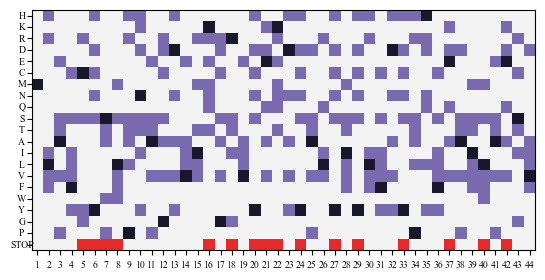

In [105]:
# plot
font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 8}
plt.rc('font', **font)

# just need to add red to highlight the stop variants
# add a gray background for variants not made

# Set the figure size
plt.figure(figsize=(6.5, 9))

# Prepare the data
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','STOP']
data = df3[aa_list].iloc[0:44].T

# Create the seaborn heatmap
ax = sns.heatmap(data, square=True, cmap=['#E62929','#7a6bb0','#19172b'], cbar=False) # red, purple, black

# Set x-axis tick labels and font size
x_ticks = range(len(data.columns))
x_labels = data.columns

# Adjust x tick positions to be centered
adjusted_ticks = [tick + 0.5 for tick in x_ticks]
plt.xticks(adjusted_ticks, x_labels, fontsize=7)

# Rotate and center the y tick labels
plt.yticks(fontsize=7, rotation=0, ha='center')

# box the heatmap
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)

ax.set_facecolor('#F3F3F3'), # gray the background

fig = ax.get_figure()
fig.savefig(f'../data/dms_variants_210303/{protein}-1_missense-count.svg', dpi=300)


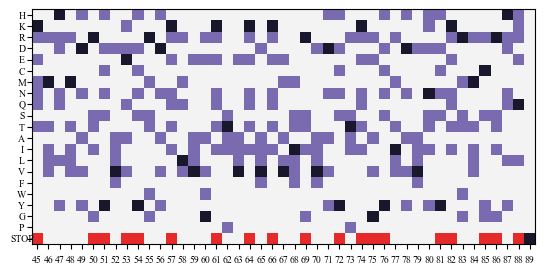

In [102]:
# Set the figure size
plt.figure(figsize=(6.5, 9))

# Prepare the data
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','STOP']
data = df3[aa_list].iloc[44:].T

# Create the seaborn heatmap
ax = sns.heatmap(data, square=True, cmap=['#E62929','#7a6bb0','#19172b'], cbar=False) # red, purple, black

# Set x-axis tick labels and font size
x_ticks = range(len(data.columns))
x_labels = data.columns

# Adjust x tick positions to be centered
adjusted_ticks = [tick + 0.5 for tick in x_ticks]
plt.xticks(adjusted_ticks, x_labels, fontsize=7)

# Rotate and center the y tick labels
plt.yticks(fontsize=7, rotation=0, ha='center')

# box the heatmap
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)

ax.set_facecolor('#F3F3F3'), # gray the background

fig = ax.get_figure()
fig.savefig(f'../data/dms_variants_210303/{protein}-2_missense-count.svg', dpi=300)


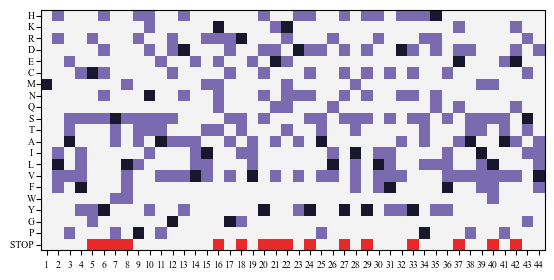

In [119]:
# plot
font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 8}
plt.rc('font', **font)

# just need to add red to highlight the stop variants
# add a gray background for variants not made

# Set the figure size
plt.figure(figsize=(6.5, 9))

# Prepare the data
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','STOP']
data = df3[aa_list].iloc[0:44].T

# Create the seaborn heatmap
ax = sns.heatmap(data, square=True, cmap=['#E62929','#7a6bb0','#19172b'], cbar=False) # red, purple, black

# Set x-axis tick labels and font size
x_ticks = range(len(data.columns))
x_labels = data.columns

# Adjust x tick positions to be centered
adjusted_ticks = [tick + 0.5 for tick in x_ticks]
plt.xticks(adjusted_ticks, x_labels, fontsize=7)

# Rotate and center the y tick labels
y_ticks = range(len(data.index))
y_labels = data.index

# Adjust y tick labels individually
y_tick_labels = []
for i, label in enumerate(y_labels):
    if i == len(y_labels) - 1:
        y_tick_labels.append(f'{label}        ')
    else:
        y_tick_labels.append(label)

adjusted_yticks = [tick + 0.5 for tick in y_ticks]
plt.yticks(adjusted_yticks, y_tick_labels, fontsize=7, rotation=0, ha='center')

# box the heatmap
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)

ax.set_facecolor('#F3F3F3'), # gray the background

fig = ax.get_figure()
#fig.savefig(f'../data/dms_variants_210303/{protein}-1_missense-count.svg', dpi=300)


In [110]:
y_labels[-1:]

Index(['STOP'], dtype='object')

In [109]:
y_labels[:-1]

Index(['H', 'K', 'R', 'D', 'E', 'C', 'M', 'N', 'Q', 'S', 'T', 'A', 'I', 'L',
       'V', 'F', 'W', 'Y', 'G', 'P'],
      dtype='object')

In [18]:
# make PKR plot
protein = "PKR"
seq = 'ATGGCTGGTGATCTTTCAGCAGGTTTCTTCATGGAGGAACTTAATACATACCGTCAGAAGCAGGGAGTAGTACTTAAATATCAAGAACTGCCTAATTCAGGACCTCCACATGATAGGAGGTTTACATTTCAAGTTATAATAGATGGAAGAGAATTTCCAGAAGGTGAAGGTAGATCAAAGAAGGAAGCAAAAAATGCCGCAGCCAAATTAGCTGTTGAGATACTTAATAAGGAAAAGAAGGCAGTTAGTCCTTTATTATTGACAACAACGAATTCTTCAGAAGGATTATCCATGGGGAATTACATAGGCCTTATCAATAGAATTGCCCAGAAGAAAAGACTAACTGTAAATTATGAACAGTGTGCATCGGGGGTGCATGGGCCAGAAGGATTTCATTATAAATGCAAAATGGGACAGAAAGAATATAGTATTGGTACAGGTTCTACTAAACAGGAAGCAAAACAATTGGCCGCTAAACTTGCATATCTTCAGATATTATCAGAAGAAACCTCAGTGAAATCTGACTACCTGTCCTCTGGTTCTTTTGCTACTACGTGTGAGTCCCAAAGCAACTCTTTAGTGACCAGCACACTCGCTTCTGAATCATCATCTGAAGGTGACTTCTCAGCAGATACATCAGAGATAAATTCTAACAGTGACAGTTTAAACAGTTCTTCGTTGCTTATGAATGGTCTCAGAAATAATCAAAGGAAGGCAAAAAGATCTTTGGCACCCAGATTTGACCTTCCTGACATGAAAGAAACAAAGTATACTGTGGACAAGAGGTTTGGCATGGATTTTAAAGAAATAGAATTAATTGGCTCAGGTGGATTTGGCCAAGTTTTCAAAGCAAAACACAGAATTGACGGAAAGACTTACGTTATTAAACGTGTTAAATATAATAACGAGAAGGCGGAGCGTGAAGTAAAAGCATTGGCAAAACTTGATCATGTAAATATTGTTCACTACAATGGCTGTTGGGATGGATTTGATTATGATCCTGAGACCAGTGATGATTCTCTTGAGAGCAGTGATTATGATCCTGAGAACAGCAAAAATAGTTCAAGGTCAAAGACTAAGTGCCTTTTCATCCAAATGGAATTCTGTGATAAAGGGACCTTGGAACAATGGATTGAAAAAAGAAGAGGCGAGAAACTAGACAAAGTTTTGGCTTTGGAACTCTTTGAACAAATAACAAAAGGGGTGGATTATATACATTCAAAAAAATTAATTCATAGAGATCTTAAGCCAAGTAATATATTCTTAGTAGATACAAAACAAGTAAAGATTGGAGACTTTGGACTTGTAACATCTCTGAAAAATGATGGAAAGCGAACAAGGAGTAAGGGAACTTTGCGATACATGAGCCCAGAACAGATTTCTTCGCAAGACTATGGAAAGGAAGTGGACCTCTACGCTTTGGGGCTAATTCTTGCTGAACTTCTTCATGTATGTGACACTGCTTTTGAAACATCAAAGTTTTTCACAGACCTACGGGATGGCATCATCTCAGATATATTTGATAAAAAAGAAAAAACTCTTCTACAGAAATTACTCTCAAAGAAACCTGAGGATCGACCTAACACATCTGAAATACTAAGGACCTTGACTGTGTGGAAGAAAAGCCCAGAGAAAAATGAACGACACACATGTTAG'
mut_pos = [(255,278),(371,385),(448,455),(480,506)]

In [19]:
seq = seq.upper()

# get list of codons
codons = [seq[i:i+3] for i in range(0, len(seq), 3)]

# make df of wt and iupac
mis_df = pd.read_csv('missense_table.csv')

data = {'codon':codons}
df = pd.DataFrame(data)
# merge the two
df = pd.merge(df, mis_df[['codon','aa','mis_var']], how='left', on='codon')

# convert string into list of characters
df.mis_var = df.mis_var.apply(lambda x:list(x))

# create a T/F df based on AA abbreviations
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
df2 = boolean_df(df.mis_var, aa_list)
df2 = df2.astype(int)

# replace all "0" with "na"
df2.replace(0,np.nan, inplace=True)

# change all 
mut_pos_list = []
for win in mut_pos:
        mut_pos_list.append(list(range(win[0]-1,win[1])))
mut_pos_list = list(itertools.chain.from_iterable(mut_pos_list))

# change all values not in filter to "na"
df2.loc[~df.index.isin(mut_pos_list)] = np.nan

# add in the wt aa with a value of "2"
df3 = df.join(df2)
for index,row in df3.iterrows():
    wt_aa = row['aa']
    df3.loc[index, wt_aa] = 2

# increase index by 1 for residue position
df3.index = df3.index + 1

# add count of missense variants
df3['variant_sum'] = df3[aa_list].sum(axis=1) - 2 #-2 is b/c wt has value of 2, remove

# mark sites within 5a of PKR
# select 5a_pkr, 2a1a within 5 of 1luz_k3l
close = [276,277,278,337,375,379,382,416,450,451,453,454,485,486,487,488,489,490,491,492,493,496,499]
df3['Within 5Å'] = np.where(df.index.isin(close), 3, np.nan)

# mark sites under positive selection
pos = [255,259,261,275,322,330,336,376,380,461,489,492,496,502,506,516,538]
df3['+ Selection'] = np.where(df.index.isin(pos), 4, np.nan)

FileNotFoundError: [Errno 2] No such file or directory: 'missense_table.csv'

In [35]:
df3.to_csv('pkr_missense-variants.csv')

In [23]:
pkr_hyper = [375, 378, 382, 405, 448, 455, 473, 480, 486, 491, 504, 524]   

[375, 378, 382, 405, 448, 455, 473, 480, 486, 491, 504, 524]

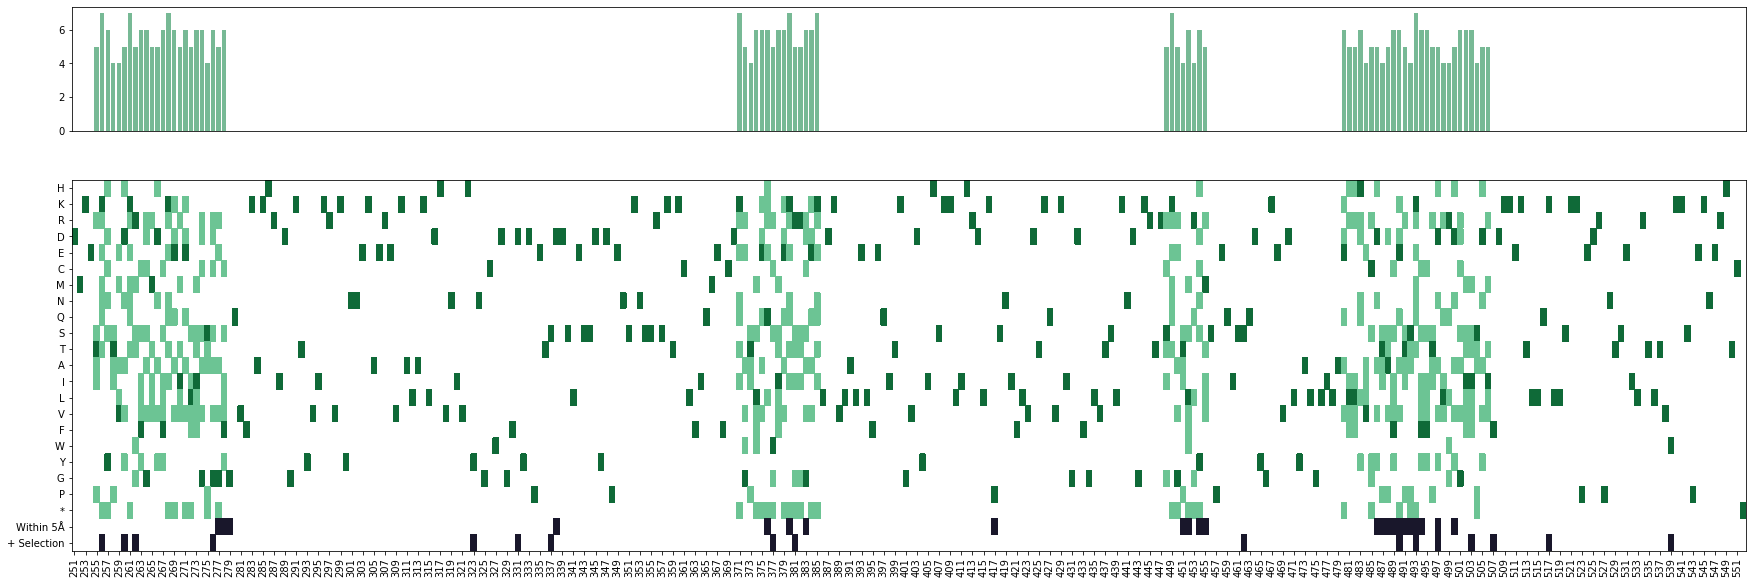

In [8]:
# try stacking the plots

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,10), gridspec_kw={'height_ratios': [1, 3]})

sn.barplot(ax=axes[0], x=df3[df.index > 249].index, y=df3[df.index > 249]['variant_sum'], palette=['#6cc494'])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])  # remove x labels
axes[0].set(xlabel=None)
axes[0].tick_params(bottom=False)  # remove the ticks
sn.heatmap(ax=axes[1], data=df3[df.index > 249][aa_list + ['Within 5Å','+ Selection']].T, cmap=['#6cc494', '#0f6a38', '#19172b', '#19172b'], cbar=False) # #0f6a38

# frame the heatmap
for _, spine in axes[1].spines.items():
    spine.set_visible(True)

# rotate heatmap y-labels
plt.yticks(rotation=0)

fig.savefig(f'{protein}_missense_variants.svg', transparent=True)

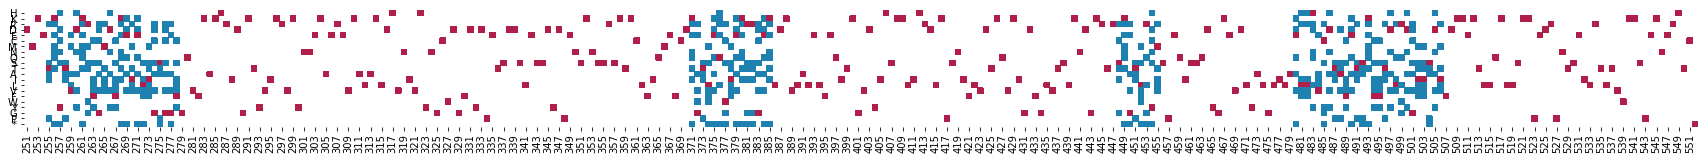

In [52]:
# plot
fig, ax = plt.subplots(figsize=(30,40))
ax = sn.heatmap(df3[df.index > 249][aa_list].T, square=True, cmap=['#1e81b0', '#b01e4a'], cbar=False)
#ax.set_title(f'{protein} Missense Variants')
plt.yticks(rotation=0)
fig = ax.get_figure()

fig.savefig(f'{protein}_missense_variants.png')

In [187]:
mut_pos_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87]